In [1]:
import numpy as np
import os,sys
import math
from sklearn.cluster import KMeans
from scipy import spatial
import scipy.stats as sp
import uproot


#--------------------------------------------------------------------------------------------------------------------------------------------

def getData(fname="", procName="Events"):
    file = uproot.open(fname)
    dq_dict = file[procName].arrays(library="np")
    dq_events = {
        "Hits":{
            "detID": dq_dict["hit_detID"],
            "edep": dq_dict["hit_edep"],
            "elmID": dq_dict["hit_elmID"],
            "hit_pos": dq_dict["hit_pos"]
        },
        "track":{
            "x": dq_dict["track_x_CAL"],
            "y": dq_dict["track_y_CAL"],
            "ID": dq_dict["eventID"],
            "pz": dq_dict["track_pz_st1"]
        },
        "st23": {
            "ntrack23": dq_dict["n_st23tracklets"],
            "px":   dq_dict["st23tracklet_px_st3"],
            "py":   dq_dict["st23tracklet_py_st3"],
            "pz":   dq_dict["st23tracklet_pz_st3"],
            "x":   dq_dict["st23tracklet_x_st3"],
            "y":   dq_dict["st23tracklet_y_st3"],
            "z":   dq_dict["st23tracklet_z_st3"],
            "Cal_x": dq_dict["st23tracklet_x_CAL"],
            "Cal_y": dq_dict["st23tracklet_y_CAL"]
        }
    }

    return dq_events
#--------------------------------------------------------------------------------------------------------------------------------------------

ntowersx=72
ntowersy=36
sizex=5.53 # in cm
sizey=5.53 # in cm
ecalx=[-200,200] #size in cm
ecaly=[-100,100]
binsx=ecalx[1]- ecalx[0]
binsy=ecaly[1]- ecaly[0]
sfc = 0.1146337964120158 #sampling fraction of emcal
emin=0.0005
det_z={41: 2130.27, 42: 2146.45, 43:2200.44 , 44:2216.62 , 45:2251.71 , 46: 2234.29}


#--------------------------------------------------------------------------------------------------------------------------------------------

def emcal_bytuple(dq_events):
    dq_hits = dq_events["Hits"]
    x_pos = []
    y_pos = []
    eve_energy = []
    for i in range(len(dq_events["Hits"]["edep"])):
        output = emcal_byevent(dq_hits, i)
        if len(output[0]) != 0:
            x_pos.append(output[0])
            y_pos.append(output[1])
            eve_energy.append(output[2])
        else:
            x_pos.append(np.array([]))
            y_pos.append(np.array([]))
            eve_energy.append(np.array([]))
            
    return x_pos, y_pos, eve_energy

#--------------------------------------------------------------------------------------------------------------------------------------------

def emcal_byevent(dq_hits, evtNum):
    raw_elmID = dq_hits["elmID"][evtNum]
    raw_edep = dq_hits["edep"][evtNum]
    
    emcal_mask = dq_hits["detID"][evtNum] == 100
    eng_mask = raw_edep[emcal_mask] >= emin
    
    elmID = raw_elmID[emcal_mask][eng_mask]#could also use dstack here to zip (elmID and edep)
    edep = raw_edep[emcal_mask][eng_mask]
    
    emcal_towerx = elmID // ntowersy
    emcal_towery = elmID % ntowersy
    emcal_x = ecalx[0] + emcal_towerx * sizex
    emcal_y = ecaly[0] + emcal_towery * sizey
    emcal_edep = edep / sfc
    
    return emcal_x, emcal_y, emcal_edep

#--------------------------------------------------------------------------------------------------------------------------------------------

def find_energy_seeds(x, y, energy, min_energy=1, seed_radius=50):
    high_energy_mask =energy >min_energy
    high_energy_points = np.column_stack((x[high_energy_mask], y[high_energy_mask], energy[high_energy_mask]))
    seeds = []
    indices = []
    for i, (x_val, y_val, energy_val) in enumerate(high_energy_points):
        distances = np.array(np.sqrt((high_energy_points[:, 0] - x_val)**2 + (high_energy_points[:, 1] - y_val)**2))
        distances[i] = seed_radius + 1
        points_within_radius_mask = distances < seed_radius
        points_within_radius = high_energy_points[points_within_radius_mask]
        if len(points_within_radius) == 0 or energy_val > np.max(points_within_radius[:, 2], initial=0):
            seeds.append((x_val, y_val))
            indices.append(np.where(high_energy_mask)[0][i])
            
    return np.array(seeds), indices
    
#--------------------------------------------------------------------------------------------------------------------------------------------
def multi_clusters(dq_events):
    (x, y, eng)=emcal_bytuple(dq_events)
    labels=[]
    seeds=[]
    labels_decrease=[]
    seed_labels = []
    kmeans_ctr = []
    for i in range(len(eng)):
        (seed, index)=find_energy_seeds(x[i], y[i], eng[i])
        seeds.append(seed)
        points=np.column_stack((x[i],y[i]))
        try:
            kmeans = KMeans(n_clusters=len(seed), random_state=0, n_init="auto").fit(points)
            labels.append(kmeans.labels_)
            label_decr = label_clus_eng(kmeans.labels_, eng[i])
            labels_decrease.append(label_decr)
            seed_labels.append(kmeans.labels_[index])
            kmeans_ctr.append(kmeans.cluster_centers_)
        except:
            labels.append([])
            labels_decrease.append([])
            seed_labels.append([])
            kmeans_ctr.append([])
    return x, y, eng, labels, labels_decrease, seeds, seed_labels, kmeans_ctr
#--------------------------------------------------------------------------------------------------------------------------------------------

def label_clus_eng(label, eng_eve):#return sorted labels by decreasing order of energy
    unique_labels = np.unique(label)
    cluster_energy = np.zeros(len(unique_labels), dtype=np.int64)
    for i in range(len(label)):
        cluster_energy[label[i]] += eng_eve[i]
    sorted_labels = unique_labels[np.argsort(cluster_energy)[::-1]]
    return sorted_labels

#--------------------------------------------------------------------------------------------------------------------------------------------

def h4_bytuple(dq_events):
    dq_hits = dq_events["Hits"]
    

    hits = np.squeeze(np.dstack((dq_hits["detID"], dq_hits["hit_pos"])), axis=0)

    h4x = []
    h4y = []

    for index, item in enumerate(hits):
        h4x_mask = (41 <= item[0]) & (item[0] <= 44)
        h4y_mask = (45 <= item[0]) & (item[0] <= 46)
        ID_pos = np.squeeze(np.dstack((hits[index][0],hits[index][1])), axis=0)
        h4x.append(ID_pos[h4x_mask])
        h4y.append(ID_pos[h4y_mask])
    return h4x, h4y

#--------------------------------------------------------------------------------------------------------------------------------------------
def gen_wew(x_eve, y_eve, eng_eve):
    eng_tot = np.sum(eng_eve)
    x_bar = np.dot(x_eve, eng_eve) / eng_tot
    y_bar = np.dot(y_eve, eng_eve) / eng_tot

    x_sq_eve = eng_eve * (x_eve - x_bar) ** 2
    y_sq_eve = eng_eve * (y_eve - y_bar) ** 2

    try:
        wew_x = np.sqrt(np.sum(x_sq_eve) / eng_tot)
    except ZeroDivisionError:
        wew_x = -1

    try:
        wew_y = np.sqrt(np.sum(y_sq_eve) / eng_tot)
    except ZeroDivisionError:
        wew_y = -1

    return [wew_x, wew_y]
#--------------------------------------------------------------------------------------------------------------------------------------------
def gen_wid(x_eve, y_eve):
    x_bar = np.mean(x_eve)
    y_bar = np.mean(y_eve)

    x_sq_eve = (x_eve - x_bar) ** 2
    y_sq_eve = (y_eve - y_bar) ** 2

    try:
        wid_x = np.sqrt(np.mean(x_sq_eve))
    except ZeroDivisionError:
        wid_x = -1

    try:
        wid_y = np.sqrt(np.mean(y_sq_eve))
    except ZeroDivisionError:
        wid_y = -1

    return [wid_x, wid_y]
#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------







In [3]:
#this function is gaining data for training
file1='/Users/wongdowling/Desktop/DQ_Dowling/ntuple_1000/electron_520_1000eve.root'
file2='/Users/wongdowling/Desktop/n-tuples/aprime_yongbin/Aee_test_eps9.root'
file3='/Users/wongdowling/Desktop/DQ_Dowling/ntuple_1000/muon_520_1000eve.root'
file4='/Users/wongdowling/Desktop/n-tuples/aprime_cmantill/Amm_1.85_56_1000.root'

dq_events = getData(file2, "Events")

(x, y, eng, labels, labels_decrease, seeds, seed_labels, kmeans_ctr) = multi_clusters(dq_events)
(h4x, h4y) = h4_bytuple(dq_events)

dq_st23 = dq_events["st23"]
st23_coord = np.stack((dq_st23["x"], dq_st23["y"], dq_st23["z"], dq_st23["px"], dq_st23["py"], dq_st23["pz"]), axis=1)
st23_cal = np.stack((dq_st23["Cal_x"], dq_st23["Cal_y"]), axis=1)
for i in range(len(eng)):#evt level
    wew_evt = []
    wid_evt = []
    
    #extrapolate track here
    for index, label in enumerate(labels_decrease[i]):#cluster level
        hits_mask = (labels[i] == label)
        clus_x = x[i][hits_mask]
        clus_y = y[i][hits_mask]
        clus_eng = eng[i][hits_mask]
        wid_evt.append(gen_wid(clus_x, clus_y))
        wew_evt.append(gen_wew(clus_x, clus_y, clus_eng))
        
        seed = seeds[i][seed_labels[i] == label].flatten()
        if len(seed)!=2:#there are some rare seed doesn't work, just use geometric center
            seed = kmeans_ctr[i][index]
            
        
            
        
        
    
    
        

In [19]:
#here is the code for match up track
def extend_track(evt_coord, evt_cal):
    y_pos = np.array([2130.27, 2146.45, 2200.44, 2216.62])
    x_pos = np.array([2251.71, 2234.29])
    
    transpose_coord = np.array(evt_coord.tolist()).T

    for i in range(len(evt_coord)):
    h4x = evt_coord[i][1] + (evt_coord[i][4] / evt_coord[i][5]) * (x_pos - evt_coord[i][2])
    h4y = evt_coord[i][1] + (evt_coord[i][4] / evt_coord[i][5]) * (y_pos - evt_coord[i][2])
    
    # Append the results to the lists
    h4x_result.append(h4x)
    h4y_result.append(h4y)
    
        

    

SyntaxError: incomplete input (602236432.py, line 4)

In [4]:
st23_coord[5]

array([array([-6.3575706, 83.79098  ], dtype=float32),
       array([  7.152227, -40.77484 ], dtype=float32),
       array([1896.795 , 1859.6442], dtype=float32),
       array([-0.21386184,  2.3349137 ], dtype=float32),
       array([ 0.25932026, -1.4942542 ], dtype=float32),
       array([49.7627 , 47.04251], dtype=float32)], dtype=object)

In [16]:
a=np.array(st23_coord[5].tolist()).T

In [ ]:
for i in range(len(evt_coord)):
    h4x = evt_coord[i][1] + (evt_coord[i][4] / evt_coord[i][5]) * (x_pos - evt_coord[i][2])
    h4y = evt_coord[i][1] + (evt_coord[i][4] / evt_coord[i][5]) * (y_pos - evt_coord[i][2])

In [ ]:
for item in a:
    h4x = a[1]

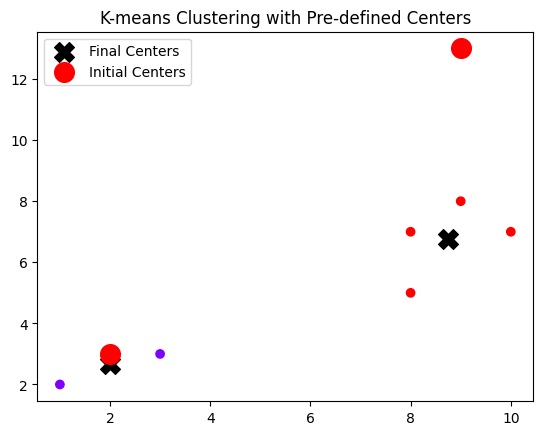

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Sample data points
data = np.array([
    [2, 3],
    [3, 3],
    [1, 2],
    [8, 7],
    [9, 8],
    [10, 7],
    [8, 5]
])

# Pre-defined cluster centers
initial_centers = np.array([
    [2, 3],  # Center 1
    [9, 13]   # Center 2
])

# Initialize K-means with pre-defined centers
kmeans = KMeans(n_clusters=initial_centers.shape[0], init=initial_centers, n_init=1)
kmeans.fit(data)

# Get cluster assignments for each data point
cluster_assignments = kmeans.labels_

# Get the final cluster centers
final_centers = kmeans.cluster_centers_

# Plot the data points and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_assignments, cmap='rainbow')
plt.scatter(final_centers[:, 0], final_centers[:, 1], marker='X', s=200, c='black', label='Final Centers')
plt.scatter(initial_centers[:, 0], initial_centers[:, 1], marker='o', s=200, c='red', label='Initial Centers')
plt.legend()
plt.title('K-means Clustering with Pre-defined Centers')
plt.show()


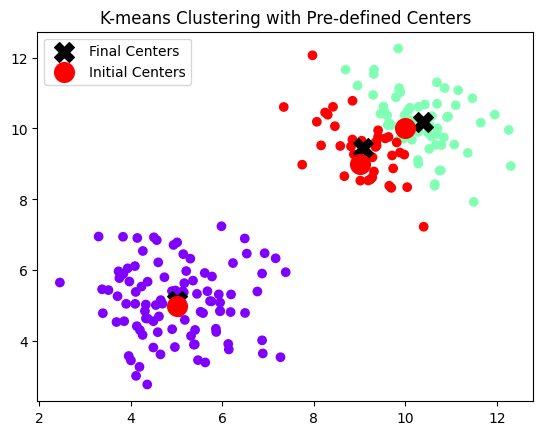

In [5]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Generate random data points in two clusters
np.random.seed(0)
cluster1 = np.random.randn(100, 2) + np.array([5, 5])
cluster2 = np.random.randn(100, 2) + np.array([10, 10])

# Combine the data points into one dataset
data = np.vstack([cluster1, cluster2])

# Pre-defined cluster centers
initial_centers = np.array([
    [5, 5],    # Center 1
    [10, 10],   # Center 2
    [9, 9]
])

# Initialize K-means with pre-defined centers
kmeans = KMeans(n_clusters=initial_centers.shape[0], init=initial_centers, n_init=1)
kmeans.fit(data)

# Get cluster assignments for each data point
cluster_assignments = kmeans.labels_

# Get the final cluster centers
final_centers = kmeans.cluster_centers_

# Plot the data points and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=cluster_assignments, cmap='rainbow')
plt.scatter(final_centers[:, 0], final_centers[:, 1], marker='X', s=200, c='black', label='Final Centers')
plt.scatter(initial_centers[:, 0], initial_centers[:, 1], marker='o', s=200, c='red', label='Initial Centers')
plt.legend()
plt.title('K-means Clustering with Pre-defined Centers')
plt.show()
